In [1]:
import os, sys
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# PYTORCH APPROACH

#### Custom dataset

In [2]:
from torch.utils.data import Dataset

In [3]:
class ROOT_dataset(Dataset):
    '''
        This class is used to:
            - read a root file;
            - get all relevant histograms in the root file and convert them to 1d numpy arrays;
            - read the csv file with labels corresponding to the histograms;
            - match the 1d numpy arrays with the labels;
            - return the matched data as a dataset.
        Input: 
            - annotation_file: the csv file with the labels;
            - root_file: the root file with histograms;
        Output:
            - pytorch dataset ready to be used for the training of a neural network.
    '''
    def __init__(self, annotation_file, path_to_root_file, histtype='hist_0'):
        self.root_annotated = pd.read_csv(annotation_file)
        self.root_file, self.all_histtype_keys = self.read_root(path_to_root_file, histtype=histtype)
        self.histtype = histtype
        self.listCHN = self.root_annotated['#Ch.#'].tolist()
        # self.primary_target_cols = ['t', 'E(t)', 'A_0', 'E(A_0)', 't_p', 'E(t_p)', 'k3', 'E(k3)', 'k4', 'E(k4)', 'k5', 'E(k5)', 'k6', 'E(k6)', 'Chi2/DOF']
        self.primary_target_cols = ['t', 'A_0', 't_p', 'k3', 'k4', 'k5', 'k6']

    def __len__(self):
        return len(self.root_annotated)

    def __getitem__(self, channelNumber):
        histname = '_'.join([self.histtype, 'channel', f'{channelNumber};1'])
        hist = self.get_histogram(root_data=self.root_file, histname=histname)
        if channelNumber in self.listCHN:
            target = self.root_annotated.loc[self.root_annotated['#Ch.#']==channelNumber][self.primary_target_cols]
            return hist, target.values
        else:
            return hist, None
    
    def read_root(self, filename, histtype='hist_0', filetype='rawdata'):
        root_file = uproot.open(filename)
        print(len(root_file.keys()))
        all_histtype_keys = []
        for key in root_file.keys():
            if ('RawData' not in key) and ('FitResults' not in key):
                if histtype in key:
                    all_histtype_keys.append(key)
        return root_file, all_histtype_keys

    def get_histogram(self, root_data, histname):
        TH1D_hist = root_data[histname].to_numpy()
        return TH1D_hist

In [4]:
dataset = ROOT_dataset(annotation_file='data/run_30413/run_30413_labelled.csv', path_to_root_file='raw_waveforms_run_30413.root', histtype='hist_0')
dataset.__getitem__(channelNumber=29)


33927


((array([ 6.000e+00,  1.100e+01,  1.400e+01,  1.900e+01,  2.200e+01,
          2.300e+01,  1.800e+01,  1.400e+01,  9.000e+00,  2.000e+00,
          7.100e+01,  1.196e+03,  3.741e+03,  6.197e+03,  7.224e+03,
          6.631e+03,  5.053e+03,  3.269e+03,  1.786e+03,  7.820e+02,
          2.280e+02, -1.400e+01, -8.400e+01, -8.100e+01, -4.700e+01,
         -1.300e+01,  1.600e+01,  4.300e+01,  5.700e+01,  5.900e+01,
          6.200e+01,  6.400e+01,  6.500e+01,  6.500e+01,  7.000e+01,
          7.300e+01,  7.400e+01,  7.300e+01,  6.900e+01,  6.300e+01,
          5.600e+01,  4.900e+01,  4.000e+01,  3.400e+01,  3.300e+01,
          2.900e+01,  2.800e+01,  3.200e+01,  4.000e+01,  4.600e+01,
          4.700e+01,  4.400e+01,  3.800e+01,  3.600e+01,  4.100e+01,
          4.500e+01,  4.500e+01,  4.300e+01,  4.500e+01,  5.100e+01,
          5.900e+01,  6.600e+01,  6.400e+01,  5.600e+01,  4.800e+01,
          4.900e+01,  5.100e+01,  5.300e+01,  4.900e+01,  3.900e+01,
          2.800e+01,  3.200e+01,  

In [5]:
hist, target = dataset.__getitem__(channelNumber=20)

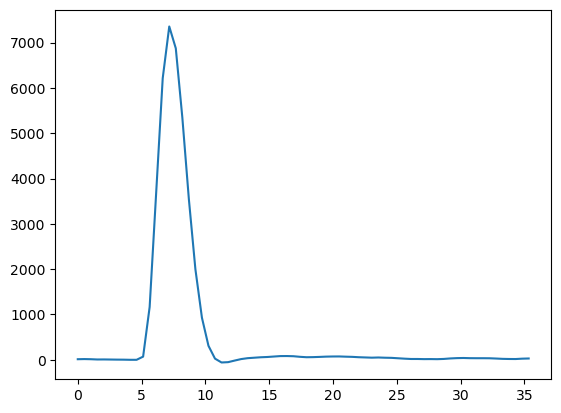

In [6]:
plt.figure()
plt.plot(hist[1][:70], hist[0][:70])
plt.show()

In [8]:
pd.DataFrame(target, columns=dataset.primary_target_cols)

,t,A_0,t_p,k3,k4,k5,k6
0,5.036479,79272.01603,2.14184,0.477705,0.567924,0.120598,0.107032


In [9]:
from torch.utils.data import DataLoader
dataset = ROOT_dataset(
    annotation_file='data/run_30413/run_30413_labelled.csv', 
    path_to_root_file='raw_waveforms_run_30413.root',
    histtype='hist_0'
)

batch_size = 16
train_loader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

33927


In [201]:
import torch
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Ti Laptop GPU'

In [202]:
import torch
from torch import nn
import torch.nn.functional as F

class EncoderWF(nn.Module):
    def __init__(self, input_channels=2, hidden_dims=(32, 64, 128), kernel_size=3, stride=1):
        pass

In [203]:
dataset[0][0][0].shape

(331,)

# Generating the waveforms using the fit parameters (simulation)

In [38]:
from response import *

In [104]:
class Sim_waveform:
    def __init__(self, path_to_sim=None, output_path=None):
        self.path_to_sim = path_to_sim
        self.output_path = output_path
        self.sim_data = pd.DataFrame()
        if self.path_to_sim is not None:
            self.sim_data = self.read_csv_sim()
        self.response_params = ['t', 'A_0', 't_p', 'k3', 'k4', 'k5', 'k6']

    def read_csv_sim(self):
        tmpdata = pd.read_csv(self.path_to_sim)
        cols = list(tmpdata.columns)
        cols_to_be_removed = [c for c in cols if 'Unnamed' in c]
        tmpdata.drop(labels=cols_to_be_removed, axis=1, inplace=True)
        tmpdata['#Ch.#'] = tmpdata['#Ch.#'].astype('int32')
        return tmpdata
    
    def __generate_1wf(self, params=None):
        if params is None:
            return None
        x = np.linspace(params[0], params[0]+70, 70)
        R = response(x=x, par=params)
        return R
    
    def run(self):
        N_samples = self.sim_data.shape[0]
        key_name = self.path_to_sim.split('/')[-1].split('.')[0].split('_')[3]
        for isample in range(N_samples):
            params = list(self.sim_data[self.response_params].iloc[isample])
            R = self.__generate_1wf(params=params)
            dict_params = dict(zip(self.response_params, params))
            dict_params['class'] = self.sim_data['class'].iloc[isample]
            dict_params['wf'] = R
            np.savez(f'{self.output_path}/wf_{key_name}_{isample}.npz', **dict_params)


In [105]:
sim_wf_obj = Sim_waveform(path_to_sim='data/labelledData/labelledData/generated_new_samples_c1_labelled_tails.csv',
                          output_path='data/labelledData/labelledData/WF_sim/')
sim_wf_obj.run()

KeyboardInterrupt: 

# BDT approach

In [12]:
import xgboost as xgb

In [ ]:
class Load_chunk_dset:
    def __init__(self, path_to_dset: str, chunk_size=5):
        self.path_to_dset = path_to_dset
        self.list_dset = ['/'.join([self.path_to_dset, f]) for f in os.listdir(self.path_to_dset)]
        self.chunk_size = chunk_size
        self.iter = 0

    def reset(self):
        self.iter = 0
        return self
    
    def load(self):
        try:
            pass
        except:
            return None
        
class PreClassifier_BDT:
    '''
        Given a waveform as input, this class will predict the fit parameters and classify them
        into four classes c1, c2, c3, c4, using a boosted decision tree.
        Inputs:
            path_to_data: path to the dataset used for training the regression and classification models.
                        This dataset located at this path should be a numpy dataset (npz) which contains the wf datapoints,
                        the fit parameters ('t', 'A_0', 't_p', 'k3', 'k4', 'k5', 'k6'), and the corresponding class ('class').
            output_path : path to where the output will be saved.
    '''
    def __init__(self, path_to_data=None, output_path=None):
        self.path_to_data = path_to_data
        self.output_path = output_path

    def prepare_dset_regression(self, output_parameters=None, N_samples=100, chunk_size=5):
        pass

    def regression(self):
        pass

    def classification(self):
        pass
    